<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Глубокое обучение. Часть 2
# Домашнее задание по теме "Механизм внимания"

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании вы будете решать задачу классификации математических задач по темам (многоклассовая классификация) с помощью Transformer.

В качестве датасета возьмем датасет математических задач по разным темам. Нам необходим следующий файл:

[Файл с классами](https://docs.google.com/spreadsheets/d/13YIbphbWc62sfa-bCh8MLQWKizaXbQK9/edit?usp=drive_link&ouid=104379615679964018037&rtpof=true&sd=true)

**Hint:** не перезаписывайте модели, которые вы получите на каждом из этапов этого дз. Они ещё понадобятся.

In [1]:
import pandas as pd

import matplotlib.pyplot as plt


dataframe_en = pd.read_csv("data_problems_translated.csv", delimiter=";", index_col=0)
dataframe_ru = pd.read_csv("data_problems.csv", delimiter=";", index_col=0, encoding="MacCyrillic")

In [2]:
print(dataframe_en.head())
print(dataframe_ru.head())

                                        problem_text          topic
#                                                                  
0  To prove that the sum of the numbers of the ex...  number_theory
1  ( b) Will the statement of the previous challe...  number_theory
2  The quadratic three-member graph with the coef...       polynoms
3  Can you draw on the surface of Rubik's cube a ...  combinatorics
4  Dima, who came from Vrunlandia, said that ther...         graphs
                                              Задача   Тема
0  Между девятью планетами Солнечной системы введ...  Графы
1  В стране Цифра есть 9 городов с названиями 1, ...  Графы
2  В государстве 100 городов, и из каждого из них...  Графы
3  В классе 30 человек. Может ли быть так, что 9 ...  Графы
4  В городе Маленьком 15 телефонов. Можно ли их с...  Графы


Ru dataset


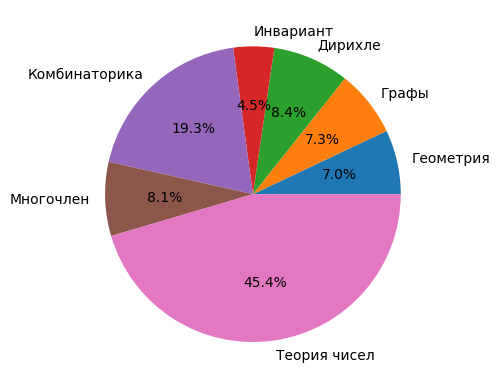

In [3]:
LABELS_RU = dataframe_ru.groupby("Тема").count().index.to_list()

plt.pie(
    dataframe_ru.groupby("Тема").count().values.squeeze(),
    labels=LABELS_RU,
    autopct=lambda pct: f"{pct:.1f}%",
)
print("Ru dataset")

En dataset


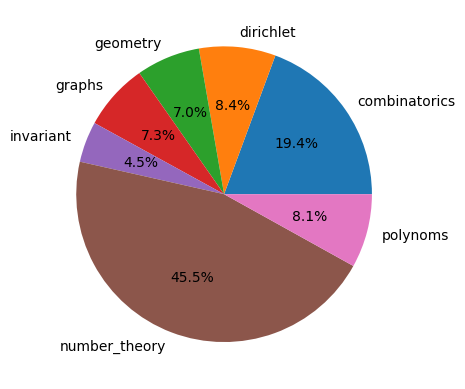

In [4]:
LABELS_EN = dataframe_en.groupby("topic").count().index.to_list()

plt.pie(
    dataframe_en.groupby("topic").count().values.squeeze(),
    labels=LABELS_EN,
    autopct=lambda pct: f"{pct:.1f}%",
)
print("En dataset")

In [5]:
dataframe_ru[~(dataframe_ru["Задача"].str.replace(".", "").str.len() > 3)].head(5)

,Задача,Тема
1,,Графы
5,\n,Графы
5,,Геометрия
3,,Многочлен
2,,Комбинаторика


In [6]:
dataframe_en[~(dataframe_en["problem_text"].str.replace(".", "").str.len() > 3)].head(5)

,problem_text,topic
#,,
36,(c),combinatorics
93,(b)..............................................,combinatorics
116,(c),combinatorics
748,(b)..............................................,polynoms
834,(b)..............................................,polynoms


----

Датасет является несбалансированным, а так же в нем присутствует 'мусор'. 

Избавимся от невалидных строк. А дизбаланс классов будем иметь ввиду)

----

In [7]:
dataframe_ru = dataframe_ru[(dataframe_ru["Задача"].str.replace(".", "").str.len() > 3)]
dataframe_en = dataframe_en[(dataframe_en["problem_text"].str.replace(".", "").str.len() > 3)]
print(dataframe_ru.count())
print("\n")
print(dataframe_en.count())

Задача    5263
Тема      5263
dtype: int64


problem_text    5240
topic           5240
dtype: int64


In [8]:
dataframe_ru = dataframe_ru.rename(columns={"Задача": "problem_text", "Тема": "topic"})

In [9]:
from typing import TypedDict, Literal

import transformers
import torch
from torch.utils.data import Dataset


class MathimaticsItem(TypedDict):
    input_ids: torch.Tensor
    token_type_ids: torch.Tensor
    attention_mask: torch.Tensor
    labels: torch.Tensor


class MathimaticsDataset(Dataset):
    """Датасетик .-."""

    def __init__(
        self,
        dataframe: pd.DataFrame,
        tokenizer_name: str,
        mode: Literal["en", "ru"] = "ru",
        max_length: int = 128,
    ):
        self.tokenizer = transformers.AutoTokenizer.from_pretrained(tokenizer_name)
        self.texts = dataframe["problem_text"].tolist()
        self.topics = dataframe["topic"].tolist()
        self.max_length = max_length
        self.labels = LABELS_EN if mode == "en" else LABELS_RU

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx: int) -> MathimaticsItem:
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )

        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item["labels"] = torch.tensor(self.labels.index(self.topics[idx]), dtype=torch.long)
        return item

### Задание 1 (2 балла)

Напишите кастомный класс для модели трансформера для задачи классификации, использующей в качествке backbone какую-то из моделей huggingface.

Т.е. конструктор класса должен принимать на вход название модели и подгружать её из huggingface, а затем использовать в качестве backbone (достаточно возможности использовать в качестве backbone те модели, которые упомянуты в последующих пунктах)

In [10]:
from torch import nn


class TransformerClassificationModel(nn.Module):
    """Модель трансформера для классификации текста."""

    def __init__(self, model_name: str, mode_lang: Literal["en", "ru"]):
        super().__init__()
        self.config = transformers.AutoConfig.from_pretrained(model_name)
        self.backbone: nn.Module = transformers.AutoModel.from_pretrained(model_name)
        labels = LABELS_EN if mode_lang == "en" else LABELS_RU

        self.classfication = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.config.hidden_size, len(labels)),
        )

    def forward(
        self,
        inputs: torch.Tensor,
        attention_mask: torch.Tensor = None,
        token_type_ids: torch.Tensor = None,
    ):
        outputs = self.backbone(
            inputs, attention_mask=attention_mask, token_type_ids=token_type_ids
        )
        if hasattr(outputs, "pooler_output") and outputs.pooler_output is not None:
            pooled_output = outputs.pooler_output
        else:
            pooled_output = outputs.last_hidden_state[:, 0]

        logits = self.classfication(pooled_output)
        return logits

### Задание 2 (1 балл)

Напишите функцию заморозки backbone у модели (если необходимо, возвращайте из функции модель)

In [11]:
def freeze_backbone_function(model: TransformerClassificationModel):
    """Замораживает слои backbone у модели."""
    model.backbone.eval()
    for param in model.backbone.parameters():
        param.requires_grad = False

### Задание 3 (2 балла)

Напишите функцию, которая будет использована для тренировки (дообучения) трансформера (TransformerClassificationModel). Функция должна поддерживать обучение с замороженным и размороженным backbone.

In [12]:
from torch.optim import AdamW
from torch.utils.data import DataLoader

from tqdm import tqdm

import copy


def train_transformer(
    transformer_model: TransformerClassificationModel,
    train_dataset,
    freeze_backbone=True,
    epochs=10,
    batch_size=16,
    learning_rate=2e-4,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
):
    model = copy.deepcopy(transformer_model)

    if freeze_backbone:
        freeze_backbone_function(model)

    model.to(device)
    model.train()

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
    history = []

    for epoch in tqdm(range(epochs)):
        total_loss = 0.0

        for batch in train_loader:
            inputs = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            token_type_ids = batch["token_type_ids"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()
            outputs = model(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        history.append(avg_loss)
    print(f"Loss: {avg_loss:.4f}")

    return model, history

### Задание 4 (1 балл)

Проверьте вашу функцию из предыдущего пункта, дообучив двумя способами
*cointegrated/rubert-tiny2* из huggingface.

In [14]:
rubert_tiny_dataset_ru = MathimaticsDataset(dataframe_ru, "cointegrated/rubert-tiny2", "ru")
rubert_tiny_dataset_en = MathimaticsDataset(dataframe_en, "cointegrated/rubert-tiny2", "en")

print("Finetuned freezed")
rubert_tiny_finetuned_freezed_ru, rubert_freezed_history_ru = train_transformer(
    TransformerClassificationModel("cointegrated/rubert-tiny2", "ru"),
    rubert_tiny_dataset_ru,
    freeze_backbone=True,
)
rubert_tiny_finetuned_freezed_en, rubert_freezed_history_en = train_transformer(
    TransformerClassificationModel("cointegrated/rubert-tiny2", "en"),
    rubert_tiny_dataset_en,
    freeze_backbone=True,
)

print("Finetuned full")
rubert_tiny_full_finetuned_ru, rubert_full_history_ru = train_transformer(
    TransformerClassificationModel("cointegrated/rubert-tiny2", "ru"),
    rubert_tiny_dataset_ru,
    freeze_backbone=False,
)
rubert_tiny_full_finetuned_en, rubert_full_history_en = train_transformer(
    TransformerClassificationModel("cointegrated/rubert-tiny2", "en"),
    rubert_tiny_dataset_en,
    freeze_backbone=True,
)

Finetuned freezed


100%|██████████| 10/10 [00:52<00:00,  5.30s/it]


Loss: 1.2461


100%|██████████| 10/10 [00:48<00:00,  4.85s/it]


Loss: 1.2769
Finetuned full


100%|██████████| 10/10 [02:19<00:00, 13.95s/it]


Loss: 0.3567


100%|██████████| 10/10 [00:49<00:00,  4.94s/it]

Loss: 1.2783


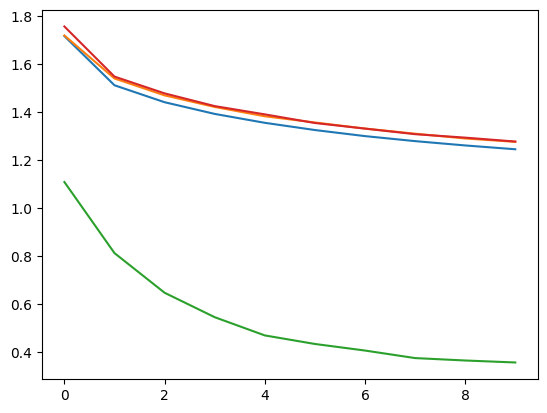

In [17]:
plt.plot(rubert_freezed_history_ru)
plt.plot(rubert_freezed_history_en)
plt.plot(rubert_full_history_ru)
plt.plot(rubert_full_history_en)
plt.show()

### Задание 5 (1 балл)

Обучите *tbs17/MathBert* (с замороженным backbone и без заморозки), проанализируйте результаты. Сравните скоры с первым заданием. Получилось лучше или нет? Почему?

In [15]:
math_bert_dataset_ru = MathimaticsDataset(dataframe_ru, "tbs17/MathBert", "ru")
math_bert_dataset_en = MathimaticsDataset(dataframe_en, "tbs17/MathBert", "en")

print("Finetuned freezed")
math_bert_finetuned_freezed, math_bert_freezed_history_ru = train_transformer(
    TransformerClassificationModel("tbs17/MathBert", "ru"),
    math_bert_dataset_ru,
    freeze_backbone=True,
)
math_bert_finetuned_freezed, math_bert_freezed_history_en = train_transformer(
    TransformerClassificationModel("tbs17/MathBert", "en"),
    math_bert_dataset_en,
    freeze_backbone=True,
)

print("Finetuned full")
math_bert_full_finetuned_ru, math_bert_full_history_ru = train_transformer(
    TransformerClassificationModel("tbs17/MathBert", "ru"),
    math_bert_dataset_ru,
    freeze_backbone=False,
)
math_bert_full_finetuned_en, math_bert_full_history_en = train_transformer(
    TransformerClassificationModel("tbs17/MathBert", "en"),
    math_bert_dataset_en,
    freeze_backbone=True,
)

Finetuned freezed


100%|██████████| 10/10 [07:11<00:00, 43.18s/it]


Loss: 1.4760


100%|██████████| 10/10 [07:02<00:00, 42.20s/it]


Loss: 1.2339
Finetuned full


100%|██████████| 10/10 [32:45<00:00, 196.52s/it]


Loss: 1.6473


100%|██████████| 10/10 [06:59<00:00, 41.98s/it]

Loss: 1.2246


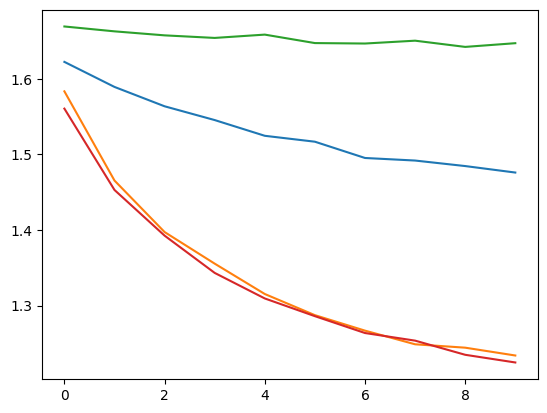

In [18]:
plt.plot(math_bert_freezed_history_ru)
plt.plot(math_bert_freezed_history_en)
plt.plot(math_bert_full_history_ru)
plt.plot(math_bert_full_history_en)
plt.show()

### Задание 6 (1 балл)

Напишите функцию для отрисовки карт внимания первого слоя для моделей из задания

In [19]:
from typing import List


import matplotlib.pyplot as plt
import torch
from typing import List
import transformers


def draw_first_layer_attention_maps(
    attention_head_ids: List[int],
    text: str,
    model: nn.Module,
    model_name: str,
):
    """
    Визуализирует attention карты первого слоя по заданным head'ам.
    """
    model.eval()

    # Включаем возврат внимания
    backbone = model.backbone
    if not backbone.config.output_attentions:
        backbone.config.output_attentions = True

    # Токенизируем
    tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    input_ids = inputs["input_ids"]
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    # Прогон через backbone с возвратом attentions
    with torch.no_grad():
        outputs = backbone(**inputs)

    # Attention shape: (batch_size, num_heads, seq_len, seq_len)
    attentions = outputs.attentions[0]  # Первый слой
    seq_len = input_ids.shape[1]

    fig, axes = plt.subplots(1, len(attention_head_ids), figsize=(4 * len(attention_head_ids), 4))
    if len(attention_head_ids) == 1:
        axes = [axes]

    for idx, head_id in enumerate(attention_head_ids):
        attn_map = attentions[0, head_id].detach().cpu().numpy()  # [seq_len, seq_len]
        ax = axes[idx]
        ax.imshow(attn_map, cmap="viridis")
        ax.set_title(f"Head {head_id}", fontsize=12)
        ax.set_xticks(range(seq_len))
        ax.set_yticks(range(seq_len))
        ax.set_xticklabels(tokens, rotation=90, fontsize=8)
        ax.set_yticklabels(tokens, fontsize=8)
        ax.grid(False)

    plt.tight_layout()
    plt.show()

### Задание 7 (1 балл)

Проведите инференс для всех моделей **ДО ДООБУЧЕНИЯ** на 2-3 текстах из датасета. Посмотрите на головы Attention первого слоя в каждой модели на выбранных текстах (отрисуйте их отдельно).

Попробуйте их проинтерпретировать. Какие связи улавливают карты внимания? (если в модели много голов Attention, то проинтерпретируйте наиболее интересные)

EN


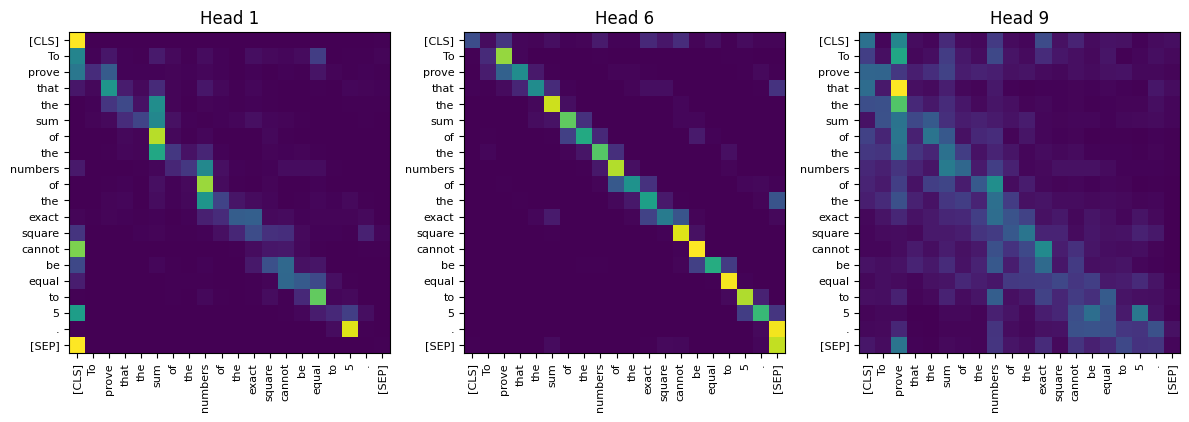

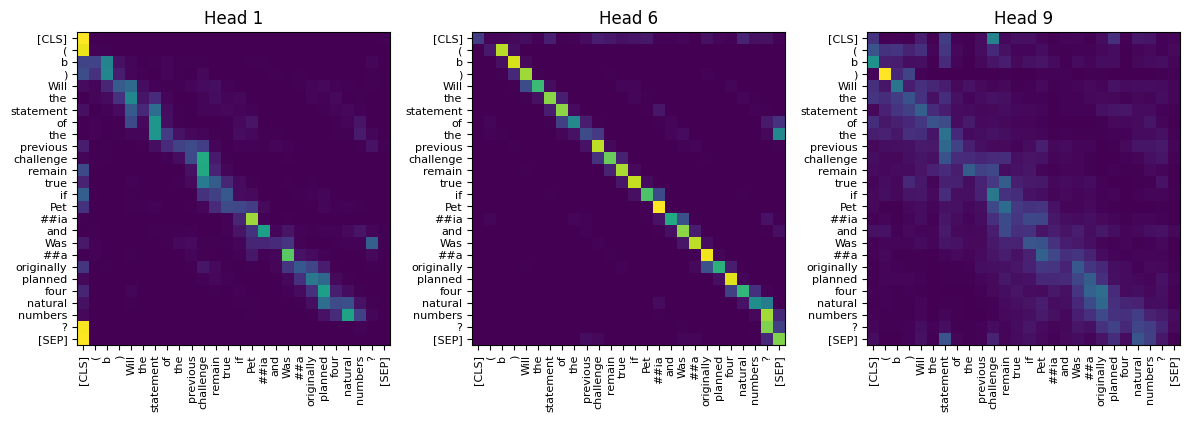

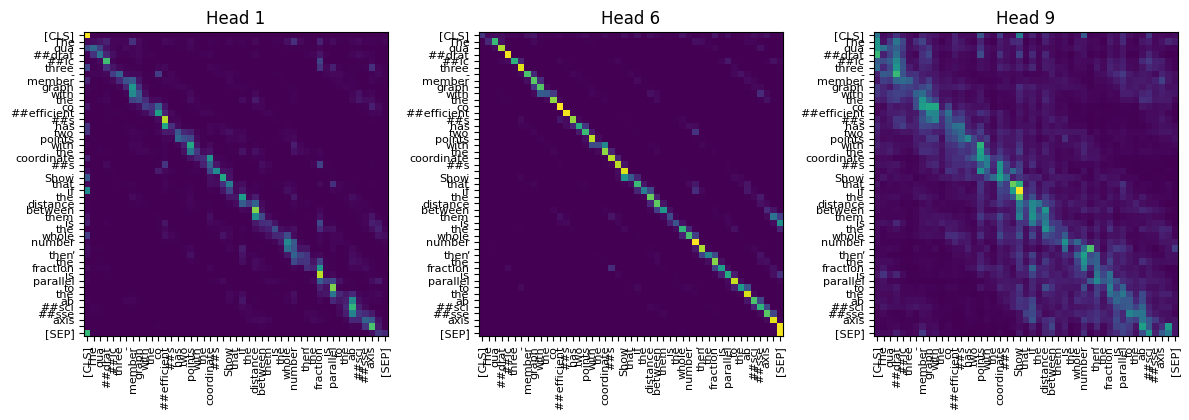

RU


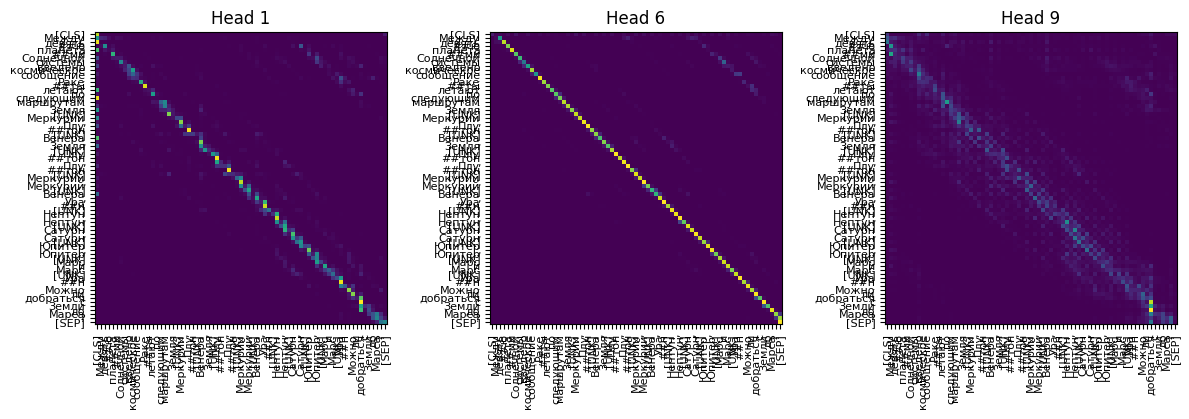

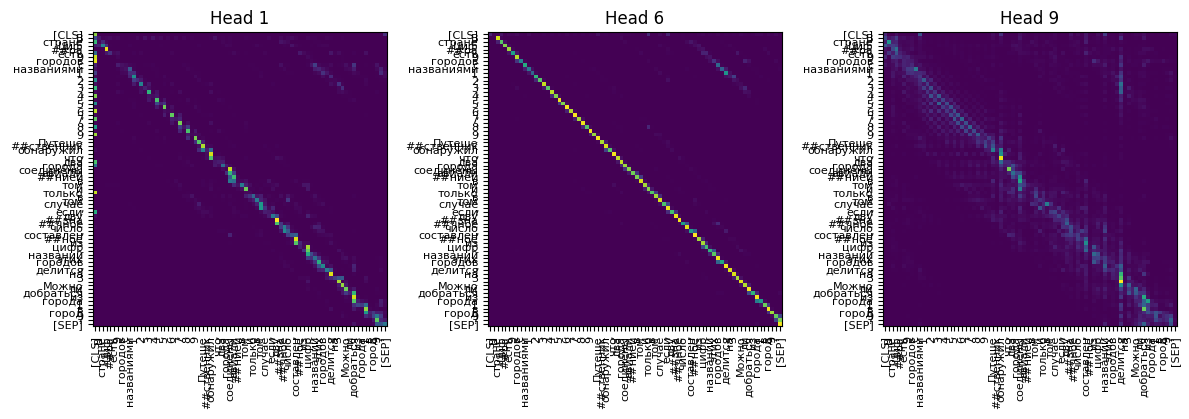

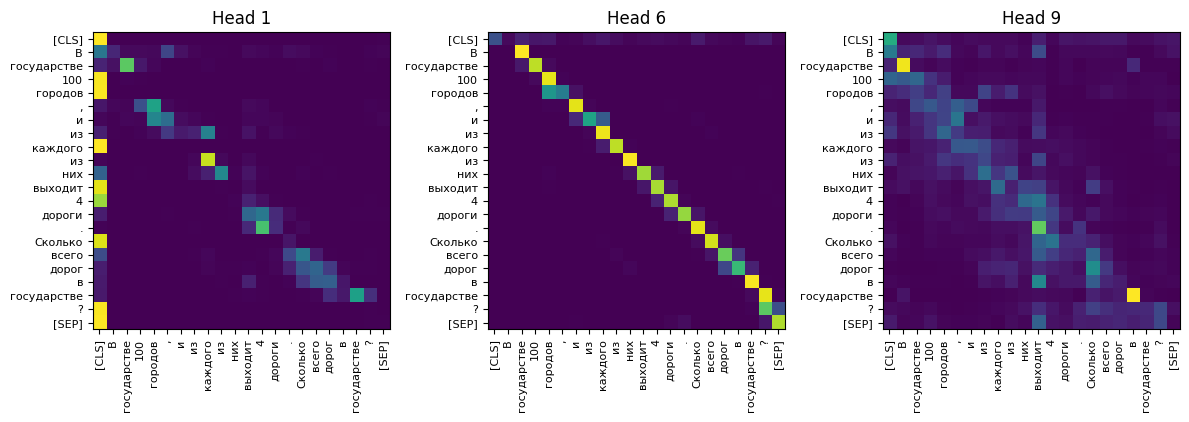

In [36]:
print("EN")
for text in dataframe_en["problem_text"][:3]:
    draw_first_layer_attention_maps(
        [1, 6, 9],
        text,
        TransformerClassificationModel("cointegrated/rubert-tiny2", "en"),
        "cointegrated/rubert-tiny2",
    )
print("RU")
for text in dataframe_ru["problem_text"][:3]:
    draw_first_layer_attention_maps(
        [1, 6, 9],
        text,
        TransformerClassificationModel("cointegrated/rubert-tiny2", "ru"),
        "cointegrated/rubert-tiny2",
    )

-----

1, 6 и 9 головы очень похожи по предназначению между особой. 1 и 9 меняют значение слова взависимости от близлежащих слов (+/-1 слово влево в право для головы 1, и +/-3 слова для головы 9), а 6 голова почти полностью сохраняет исходный смысл слова, не изменяя его значения в контексте.

----

EN


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


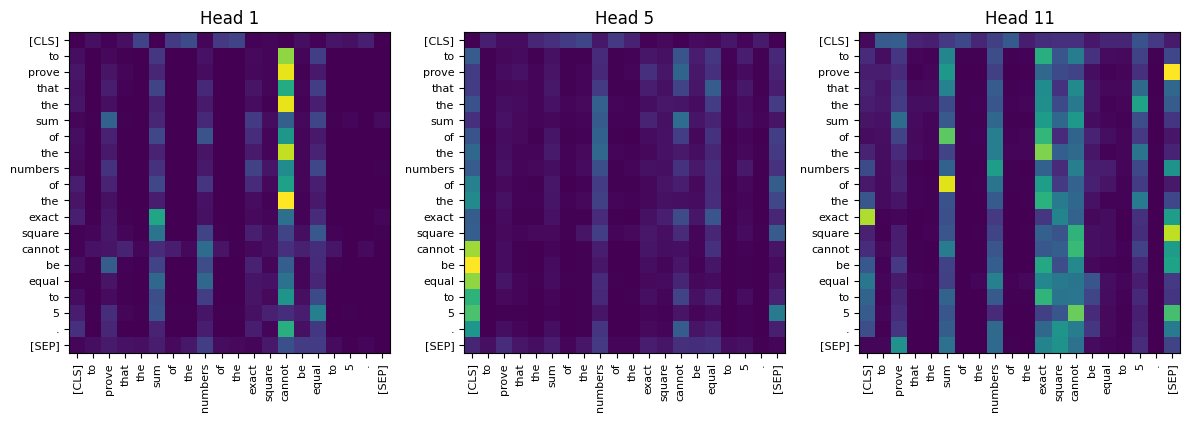

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


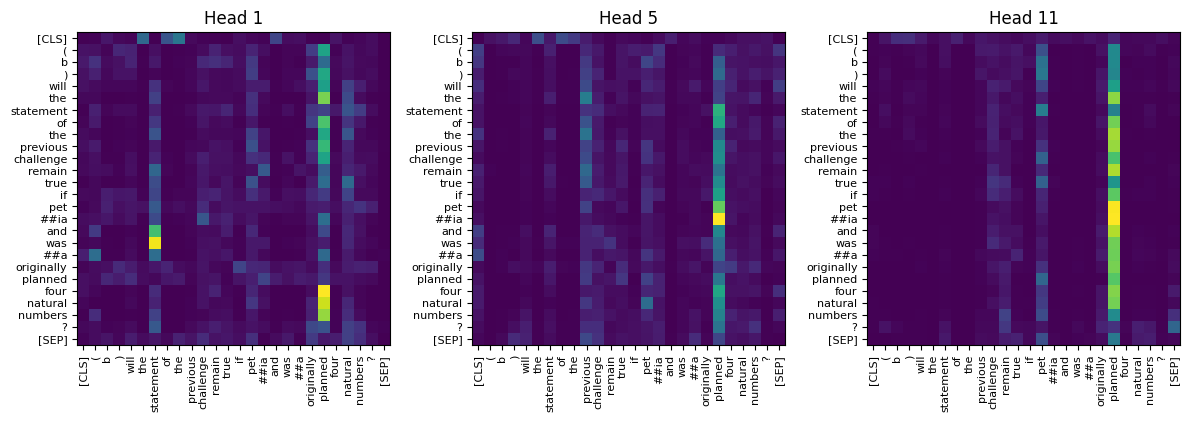

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


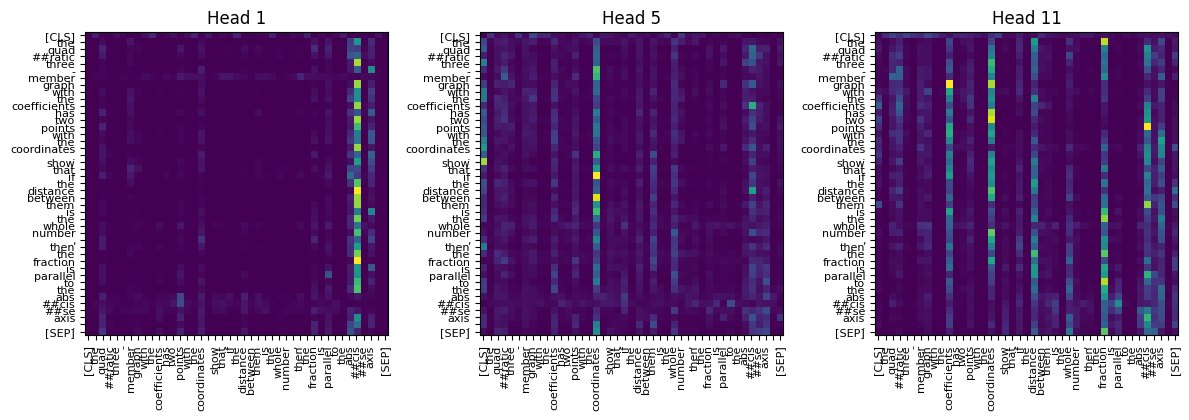

RU


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


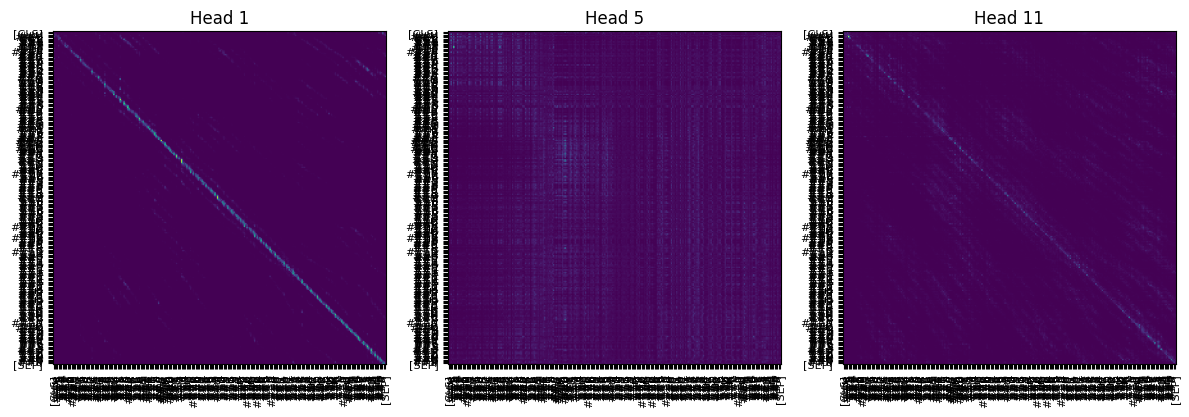

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


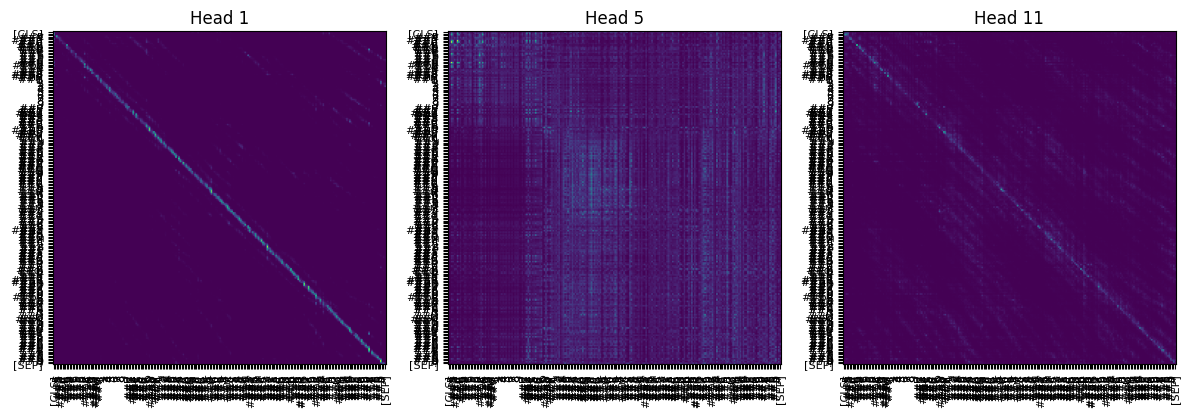

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


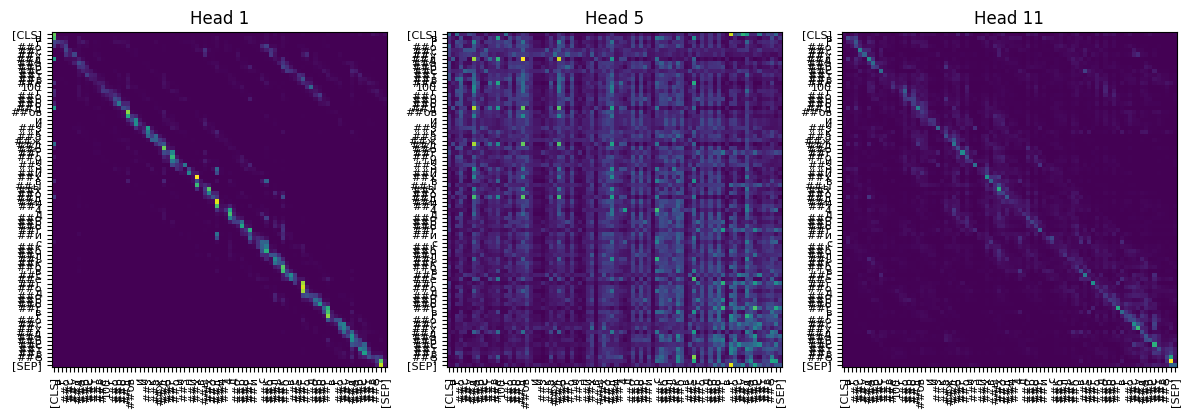

In [41]:
print("EN")
for text in dataframe_en["problem_text"][:3]:
    draw_first_layer_attention_maps(
        [1, 5, 11],
        text,
        TransformerClassificationModel("tbs17/MathBert", "en"),
        "tbs17/MathBert",
    )
print("RU")
for text in dataframe_ru["problem_text"][:3]:
    draw_first_layer_attention_maps(
        [1, 5, 11],
        text,
        TransformerClassificationModel("cointegrated/rubert-tiny2", "ru"),
        "tbs17/MathBert",
    )

-----

Данная модель странным образом реагирует на русский текст. Головы совершенно иначе обрабатывают...

1, 5 и 11 головы схожи между собой. Они выделяют ключевые слова и меняют их значение взависимости от всего контекста предложения.

----

### Задание 8 (1 балл)

Сделайте то же самое для дообученных моделей. Изменились ли карты внимания и связи, которые они улавливают? Почему?

EN
Freezed


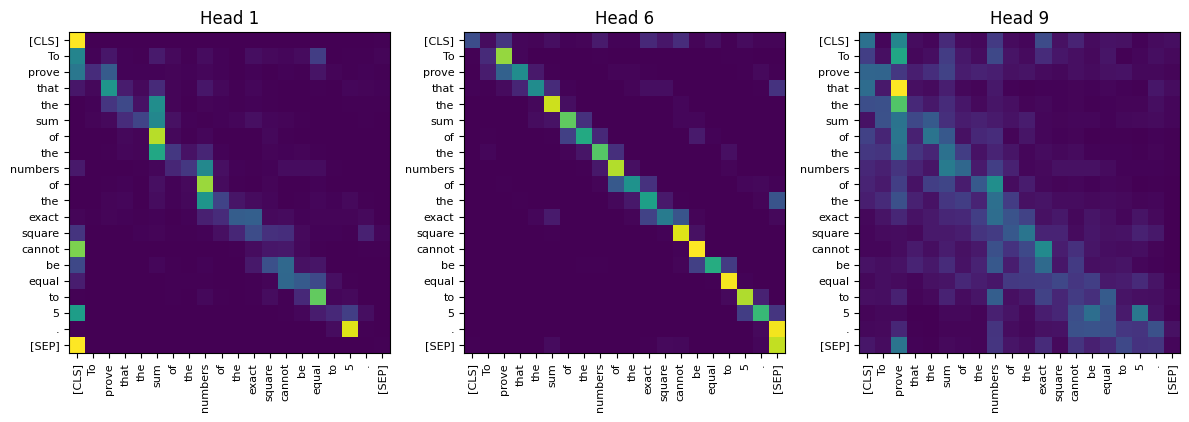

Full


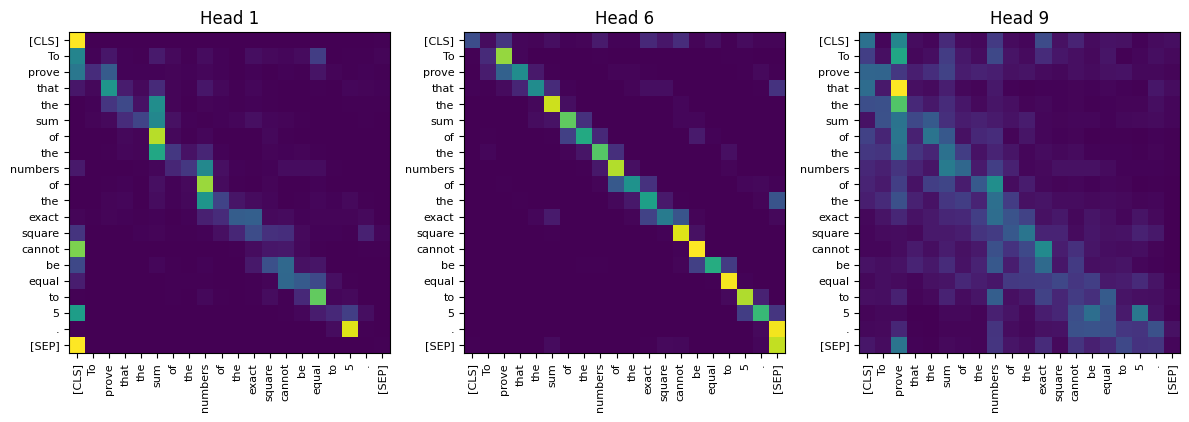

Freezed


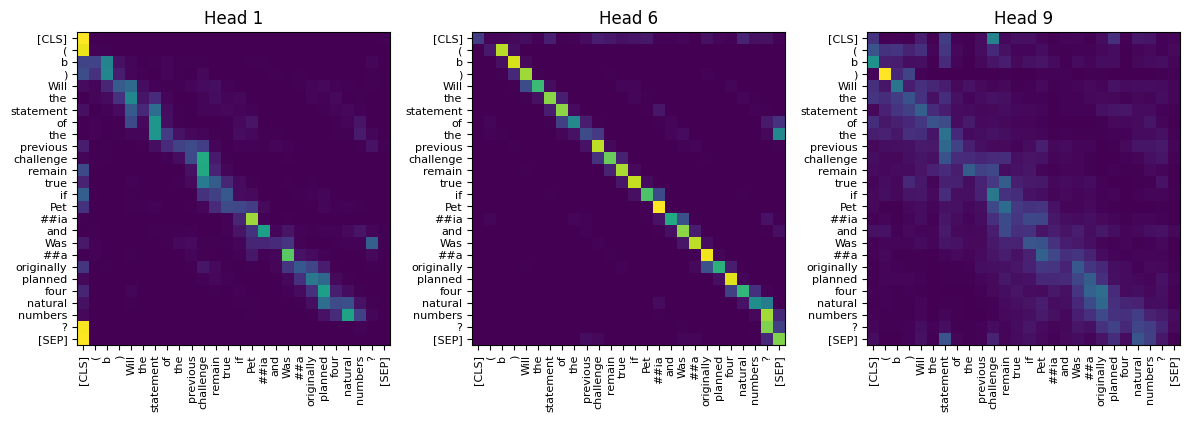

Full


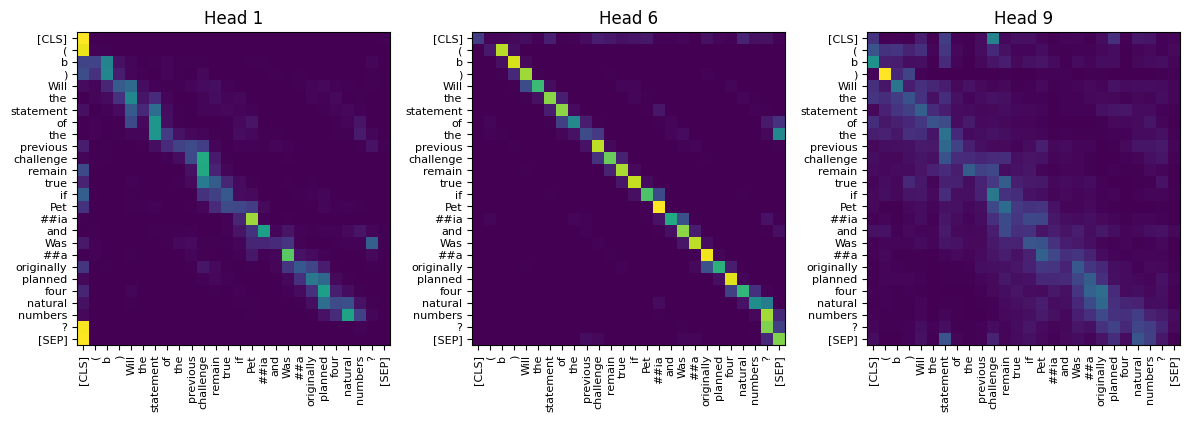

Freezed


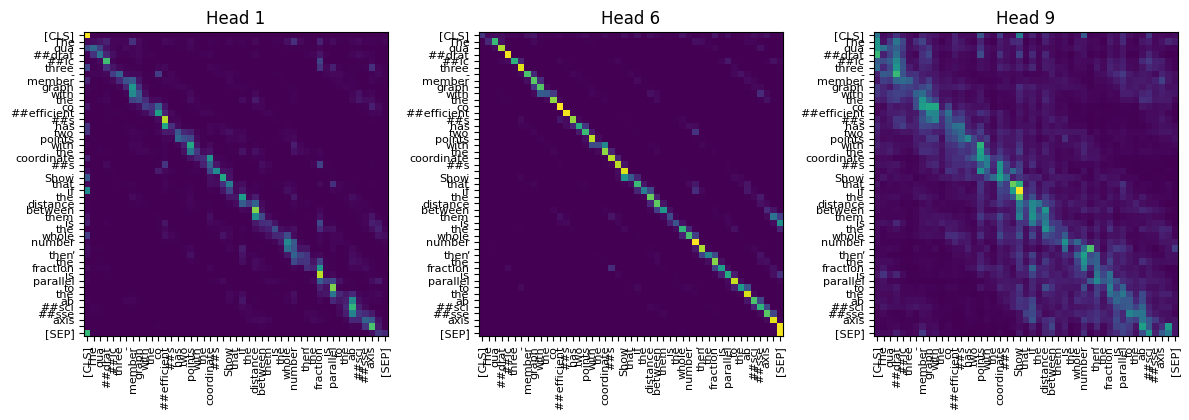

Full


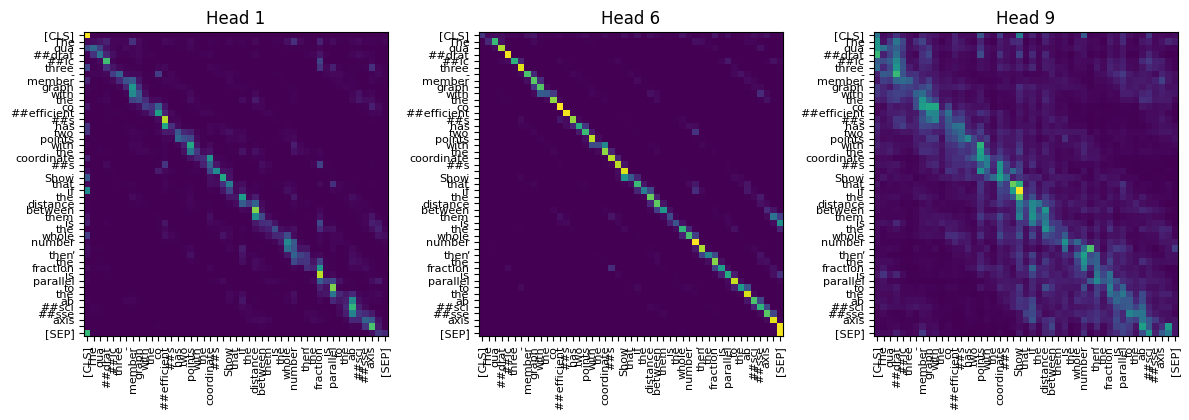

RU
Freezed


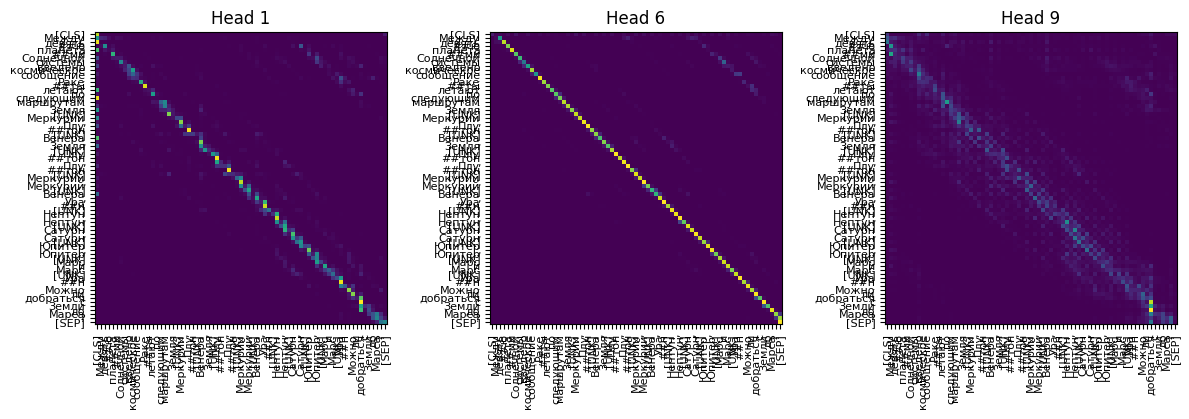

Full


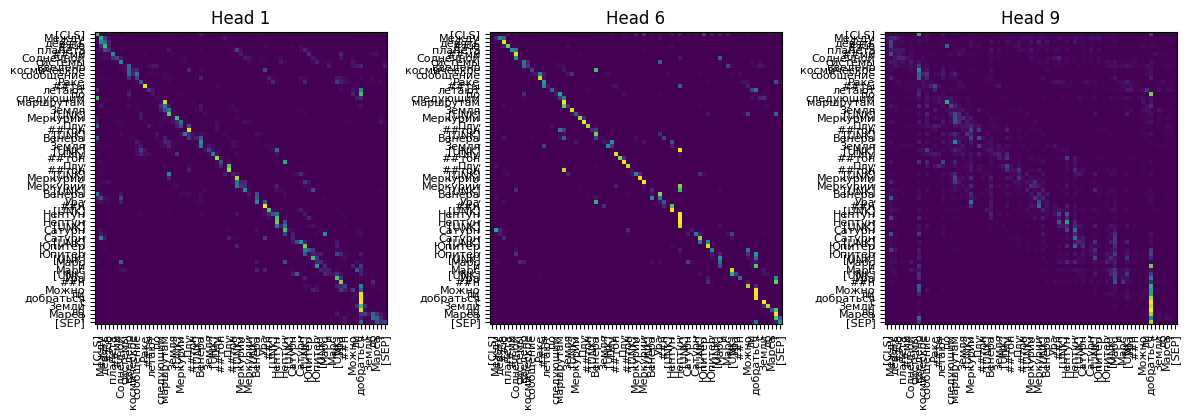

Freezed


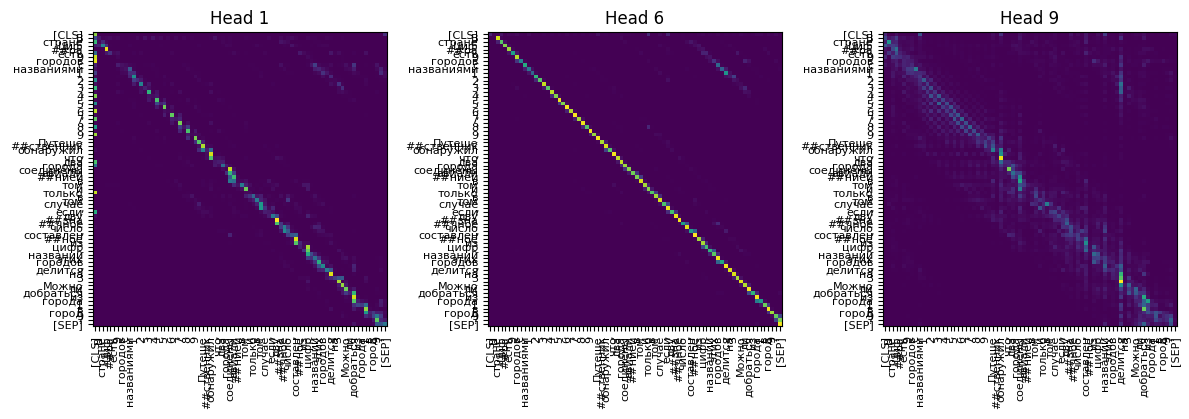

Full


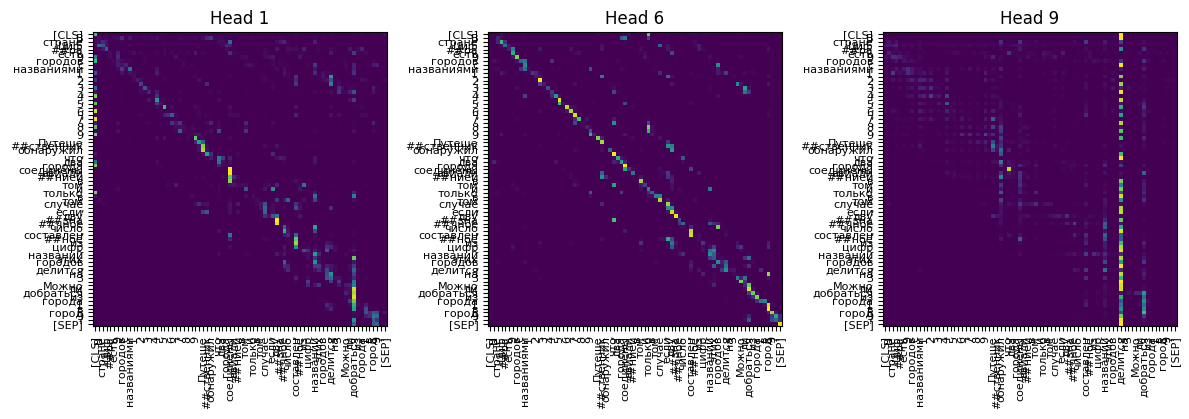

Freezed


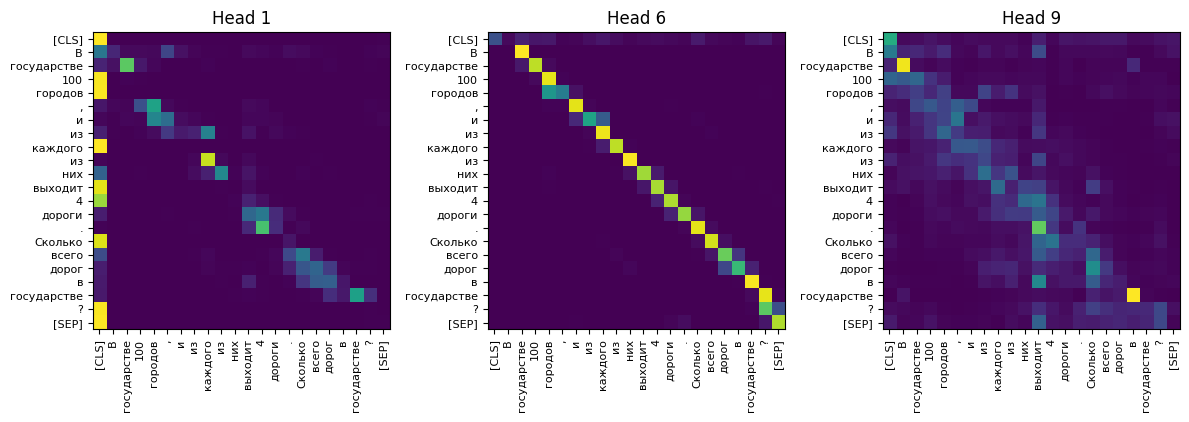

Full


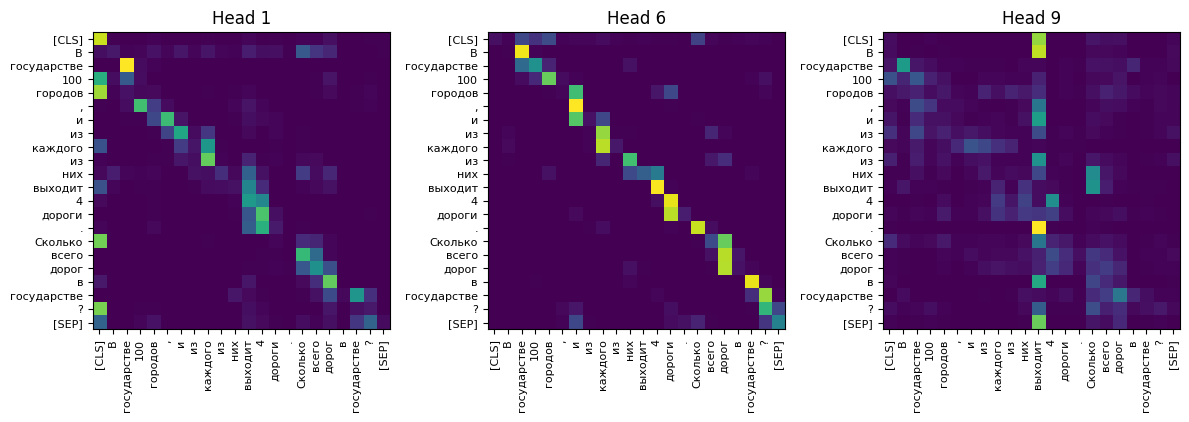

In [43]:
print("EN")
for text in dataframe_en["problem_text"][:3]:
    print("Freezed")
    draw_first_layer_attention_maps(
        [1, 6, 9],
        text,
        rubert_tiny_finetuned_freezed_en.cpu(),
        "cointegrated/rubert-tiny2",
    )
    print("Full")
    draw_first_layer_attention_maps(
        [1, 6, 9],
        text,
        rubert_tiny_full_finetuned_en.cpu(),
        "cointegrated/rubert-tiny2",
    )


print("RU")
for text in dataframe_ru["problem_text"][:3]:
    print("Freezed")
    draw_first_layer_attention_maps(
        [1, 6, 9],
        text,
        rubert_tiny_finetuned_freezed_ru.cpu(),
        "cointegrated/rubert-tiny2",
    )
    print("Full")
    draw_first_layer_attention_maps(
        [1, 6, 9],
        text,
        rubert_tiny_full_finetuned_ru.cpu(),
        "cointegrated/rubert-tiny2",
    )

EN
Freezed


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


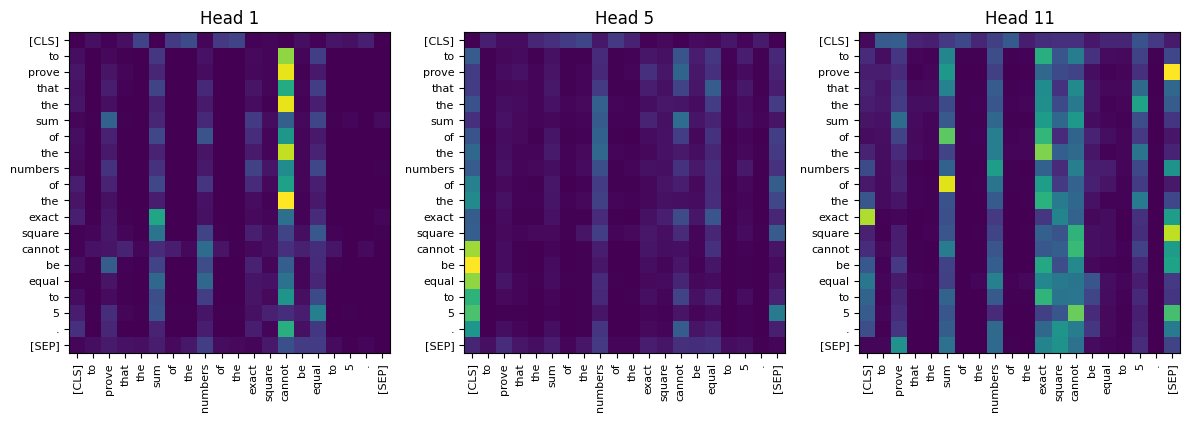

Full


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


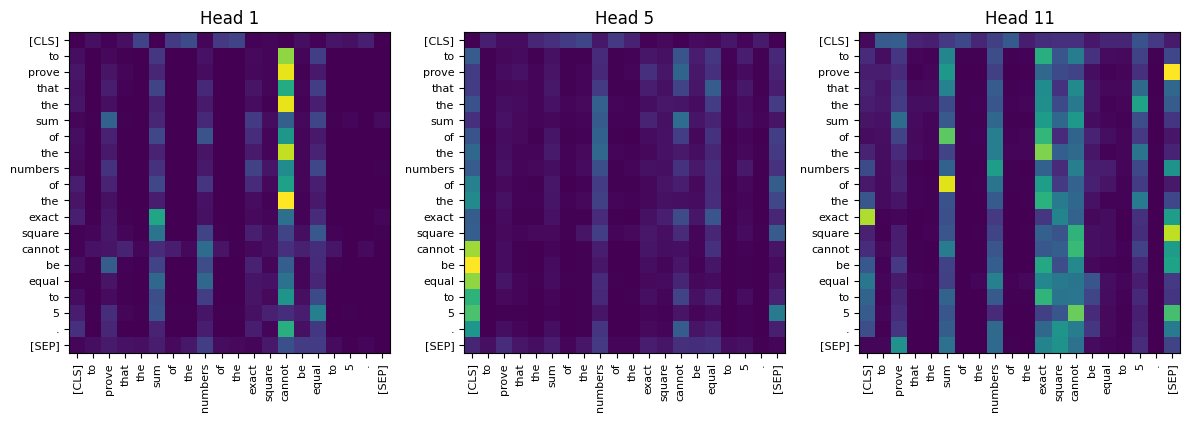

Freezed


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


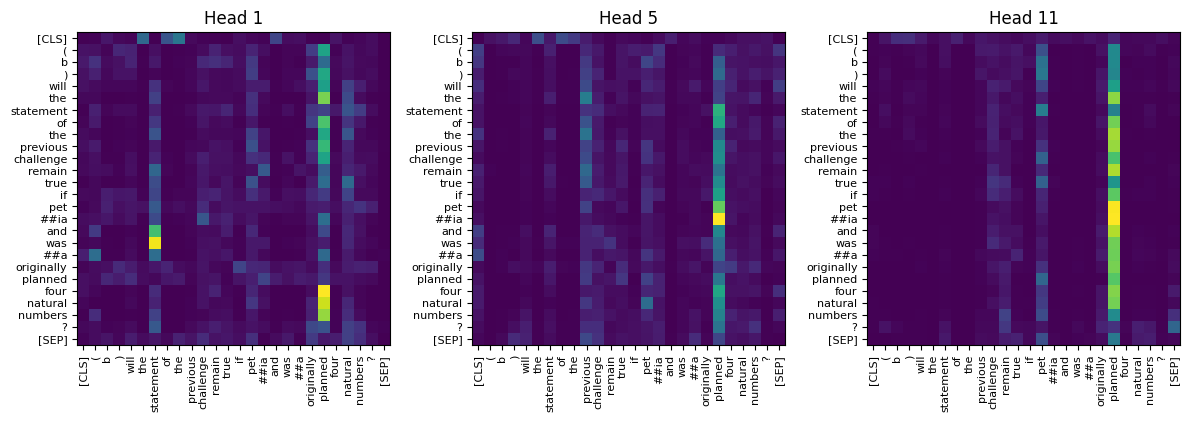

Full


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


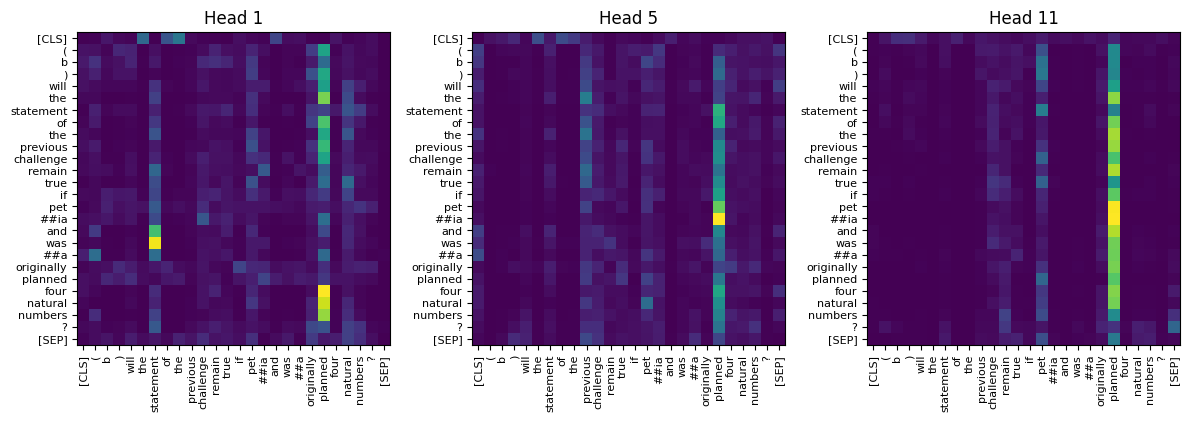

Freezed


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


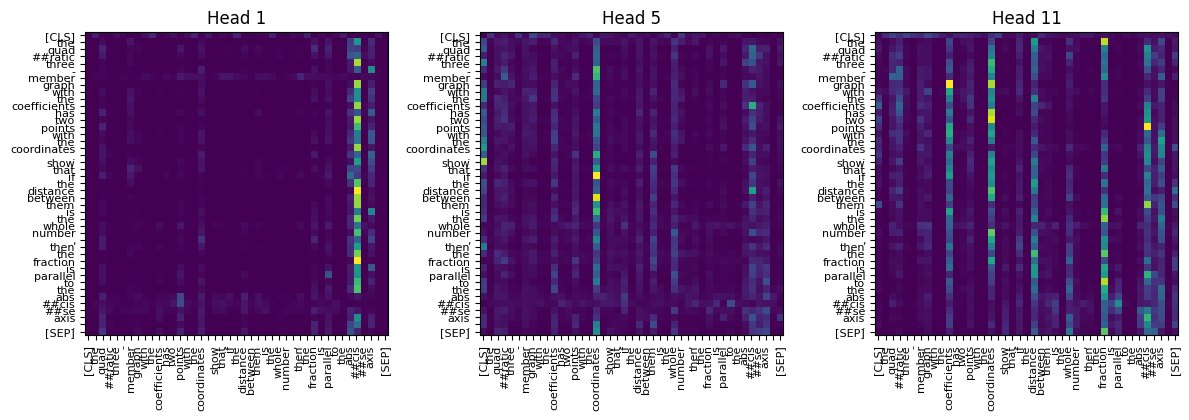

Full


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


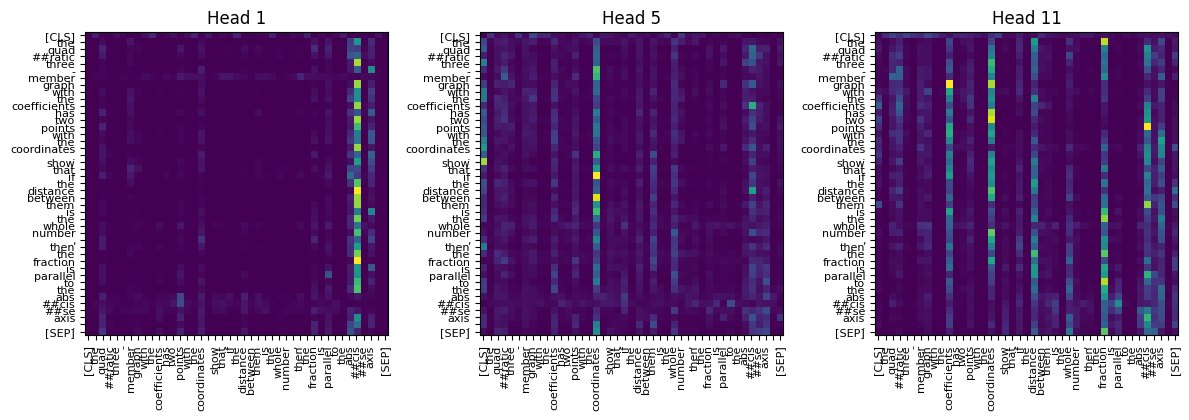

RU
Full


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


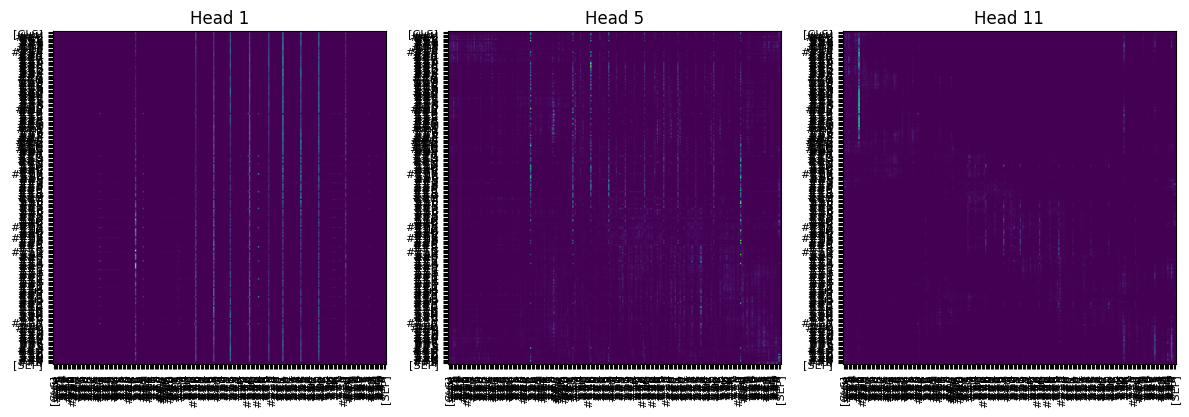

Full


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


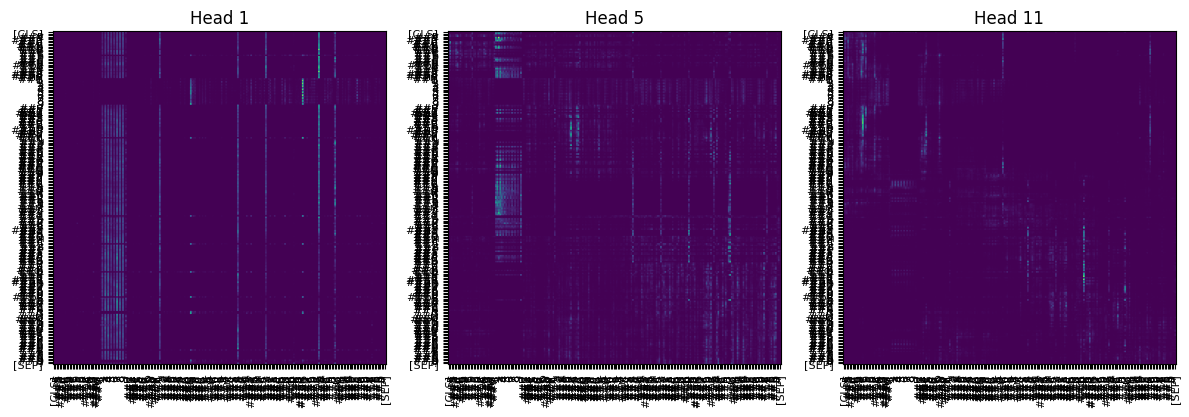

Full


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


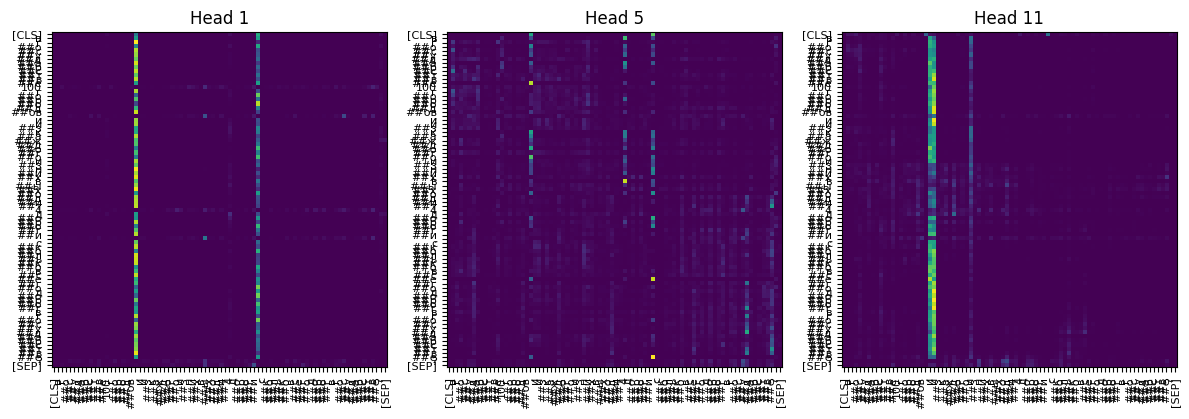

In [44]:
print("EN")
for text in dataframe_en["problem_text"][:3]:
    print("Freezed")
    draw_first_layer_attention_maps(
        [1, 5, 11],
        text,
        math_bert_finetuned_freezed.cpu(),
        "tbs17/MathBert",
    )
    print("Full")
    draw_first_layer_attention_maps(
        [1, 5, 11],
        text,
        math_bert_full_finetuned_en.cpu(),
        "tbs17/MathBert",
    )

print("RU")
for text in dataframe_ru["problem_text"][:3]:
    print("Full")
    draw_first_layer_attention_maps(
        [1, 5, 11],
        text,
        math_bert_full_finetuned_ru.cpu(),
        "tbs17/MathBert",
    )

----

Вывод:
- Обучение моделей дало более выраженную карту внимания для конкретной задачи классификации. Они сильнее подвержены ключевым словам и их значению в контексте.


----